In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import sys

In [64]:

c2 = 0.2

alpha = 1

def loss_function(a, y):
    return c2*(a-y)**2 -alpha



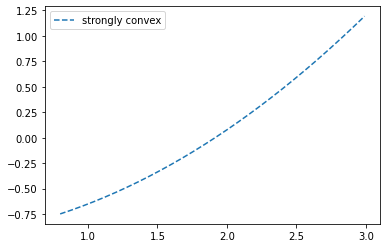

In [181]:
# evenly sampled time at 200ms intervals
thetas = np.arange(0.8, 3., 0.01)
y = np.random.normal(loc=1, scale=1)

# red dashes, blue squares and green triangles
plt.plot(thetas, loss_function(thetas, y), '--', label='strongly convex')
plt.legend()
plt.show()

In [182]:
def evaluate_theta(theta, random_seed):
    rng = np.random.RandomState(random_seed)
    size=10000
    actions = rng.normal(loc=theta, scale=1, size=size)
    y = rng.normal(loc=1, scale=0.3, size=size)
    loss = np.mean(c2*(actions-y)**2 -alpha)
    return loss
    

In [183]:
import jax
import jax.numpy as jnp
import jaxopt

def pdf(loc, x):
    scale = logging_scale
    return 1/(scale * jnp.sqrt(2*jnp.pi)) * jnp.exp(-((x - loc)/scale)**2/2)

def conservative_loss(param, data):
    logging_samples, logging_losses, logging_propensities = data
    n = logging_losses.shape[0]
    lambd = np.sqrt(18*(np.log(n)))
#     lambd = 0.01
    importance_weights = pdf(param, logging_samples)/logging_propensities
    mean = jnp.mean(logging_losses * importance_weights)
    std = jnp.std(logging_losses * importance_weights)
    return mean + lambd / np.sqrt(n) * std 



In [184]:
loss_mode = 'convex'
loss_function = loss_function

In [251]:
def optimize(loss_fun, init_parameter, args):
    lower_bounds = -100*jnp.ones_like(init_parameter)
    upper_bounds = 100*jnp.ones_like(init_parameter)
    bounds = (lower_bounds, upper_bounds)

#     lbfgsb = jaxopt.ScipyMinimize(fun=loss_fun, method="L-BFGS-B").run(init_parameter, bounds=bounds, data=args)
    lbfgsb = jaxopt.ScipyBoundedMinimize(fun=loss_fun, method="l-bfgs-b").run(init_parameter, bounds=bounds, data=args)

    lbfgs_sol = lbfgsb.params
        
    return lbfgs_sol

# Experiment

In [192]:
y_scale = 0.3

def get_logging_data(n_samples, logging_mu, logging_scale, random_seed=123):

    rng = np.random.RandomState(random_seed)
    y_0 = rng.normal(loc=1, scale=y_scale)
    action_samples = rng.normal(loc=logging_mu, scale=logging_scale, size=n_samples)
    losses = loss_function(action_samples, y_0)
    logging_pdf = norm(loc=logging_mu, scale=logging_scale).pdf
    propensities = logging_pdf(action_samples)
    loss = np.mean(losses)

    logging_data = action_samples, losses, propensities

    return logging_data


### Repeated CRM

In [193]:

def repeated_crm_experiment(logging_mu, logging_scale, settings, random_seed=123):

    loss_fun = conservative_loss 
    print('-' * 80)
    print('CRM experiment, \mu_0={}, \sigma={}, seed {}'.format(logging_mu, logging_scale, random_seed))
    
    rng = np.random.RandomState(random_seed)
    repeated_crm_online_losses = []

    M = settings['M']
    n_samples = settings['n_0']
    n_total = n_samples
    mu = logging_mu 
    logging_pdf = norm(loc=logging_mu\
                       , scale=logging_scale).pdf
    optimized_mus = [mu]
    logging_data = get_logging_data(n_samples, logging_mu, logging_scale, random_seed)
    logging_samples, logging_losses, logging_propensities = logging_data

    for m in range(M):
        print('Rollout {}'.format(m))

        init_parameter = jnp.array(logging_mu, dtype='float32')
        args = logging_data

        optimized_mu = optimize(loss_fun, init_parameter, args)
        optimized_mus.append(optimized_mu)

            
        mu = optimized_mu._value
    
        n_samples *= 2 
        y_m = rng.normal(loc=1, scale=y_scale)
        action_samples = rng.normal(loc=logging_mu, scale=logging_scale, size=n_samples)
        losses = loss_function(action_samples, y_m)
        propensities = logging_pdf(action_samples)
        online_loss = evaluate_theta(mu, random_seed)
        repeated_crm_online_losses.append(online_loss)

        logging_samples = np.hstack([logging_samples, action_samples])
        logging_losses = np.hstack([logging_losses, losses])
        logging_propensities = np.hstack([logging_propensities, propensities])
        logging_data = logging_samples, logging_losses, logging_propensities
        n_total += n_samples
    
    return repeated_crm_online_losses


# repeated_crm_online_losses = repeated_crm_experiment(thetas)


### Sequential CRM

In [194]:
def sequential_crm_experiment(logging_mu, logging_scale, settings, random_seed=123):

    loss_fun = conservative_loss 
    
    print('-' * 80)
    print('SCRM experiment, \mu_0={}, \sigma={}, seed {}'.format(logging_mu, logging_scale, random_seed))
    
    M = settings['M']
    n_samples = settings['n_0']
    
    
    
    logging_data = get_logging_data(n_samples, logging_mu, logging_scale, random_seed)
    
    rng = np.random.RandomState(random_seed)
    
    mu = logging_mu
    optimized_mus = [mu]
    sequential_crm_online_losses = []

    for m in range(M):
        
        print('Rollout {}'.format(m))
        
        init_parameter = jnp.array(mu, dtype='float32')
        args = logging_data

        optimized_mu = optimize(loss_fun, init_parameter, args)
        optimized_mus.append(optimized_mu)
        


        ### New logging data
        n_samples *= 2
        mu = optimized_mu._value

        logging_samples = rng.normal(loc=mu, scale=logging_scale, size=n_samples)
        y_m = rng.normal(loc=1, scale=y_scale)
        logging_losses = loss_function(logging_samples, y_m)
        online_loss = evaluate_theta(mu, random_seed)
        sequential_crm_online_losses.append(online_loss)
        logging_pdf = norm(loc=mu, scale=logging_scale).pdf
        logging_propensities = logging_pdf(logging_samples)


        logging_data = logging_samples, logging_losses, logging_propensities

    
    return sequential_crm_online_losses

# sequential_crm_online_losses = sequential_crm_experiment(thetas)


### Plot results

In [195]:
def do_experiment(logging_mu, logging_scale, settings):
    repeated_crm_losses = []
    sequential_crm_losses = []

    for random_seed in range(5):
        repeated_crm_losses.append(repeated_crm_experiment(logging_mu, logging_scale, settings, random_seed))
        sequential_crm_losses.append(sequential_crm_experiment(logging_mu, logging_scale, settings, random_seed))

    repeated_crm_losses = np.array(repeated_crm_losses)
    crm_losses = np.mean(repeated_crm_losses, axis=0)
    crm_losses_std = np.std(repeated_crm_losses, axis=0)

    sequential_crm_losses = np.array(sequential_crm_losses)
    scrm_losses = np.mean(sequential_crm_losses, axis=0)
    scrm_losses_std = np.std(sequential_crm_losses, axis=0)
    return crm_losses, crm_losses_std, scrm_losses, scrm_losses_std

In [196]:
# crm_perfs = []
# crm_perfs_std = []
# scrm_perfs = []
# scrm_perfs_std = []

# settings = {
#     'M':15,
#     'n_0':100
# }

# optimal_mu = 1
# delta = 0.2
# logging_mu = optimal_mu + delta

# logging_scales = [0.1, 1, 10]

# for sigma in logging_scales:
#     crm_losses, crm_losses_std, scrm_losses, scrm_losses_std = do_experiment(logging_mu, sigma, settings)
#     crm_perfs.append(crm_losses)
#     crm_perfs_std.append(crm_losses_std)
#     scrm_perfs.append(scrm_losses)
#     scrm_perfs_std.append(scrm_losses_std)

In [197]:
# plt.title(r'Loss Evolution with logging $\vert \theta^* - \theta_0 \vert={}$'.format(delta))
# plt.xlabel('Rollouts $m$')
# plt.ylabel('Loss')

# rollouts = np.arange(1, 16)

# color_pairs = [('black', 'orange'), ('purple', 'darkorange'), ('navy', 'darkgoldenrod')]
# l = len(crm_perfs)
    
# for idx in range(l):
#     color_crm, color_scrm = color_pairs[idx]
#     crm_losses = crm_perfs[idx]
#     crm_losses_std = crm_perfs_std[idx]
#     scrm_losses = scrm_perfs[idx]
#     scrm_losses_std = scrm_perfs_std[idx]
#     sigma = logging_scales[idx]
    
#     plt.plot(rollouts, crm_losses, 'x--', color=color_crm, label='CRM - $\sigma={}$'.format(sigma))
#     plt.fill_between(rollouts,
#                          crm_losses - crm_losses_std,
#                          crm_losses + crm_losses_std, alpha=.25, color=color_crm, )
#     plt.plot(rollouts, scrm_losses, 'o-', color=color_scrm, label='SCRM - $\sigma={}$'.format(sigma))
#     plt.fill_between(rollouts,
#                          scrm_losses - scrm_losses_std,
#                          scrm_losses + scrm_losses_std, alpha=.25, color=color_scrm)

# plt.legend(loc='best')
# plt.savefig('distance_variance_compromise.pdf')

In [227]:

def do_plot(delta, settings):

    crm_perfs = []
    crm_perfs_std = []
    scrm_perfs = []
    scrm_perfs_std = []

    optimal_mu = 1
    logging_mu = optimal_mu + delta

    logging_scales = [0.1, 0.3, 1, 3]
#     logging_scales = [0.3, 1]

    for sigma in logging_scales:
        crm_losses, crm_losses_std, scrm_losses, scrm_losses_std = do_experiment(logging_mu, sigma, settings)
        crm_perfs.append(crm_losses)
        crm_perfs_std.append(crm_losses_std)
        scrm_perfs.append(scrm_losses)
        scrm_perfs_std.append(scrm_losses_std)

    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))


    rollouts = np.arange(1, settings['M']+1)

    color_pairs = [('black', 'orange'), ('purple', 'green'), ('navy', 'olive'), ('royalblue','darkolivegreen'), ('blueviolet', 'y')]
    l = len(crm_perfs)

    for idx in range(l):
        color_crm, color_scrm = color_pairs[idx]
        crm_losses = crm_perfs[idx]
        crm_losses_std = crm_perfs_std[idx]
        scrm_losses = scrm_perfs[idx]
        scrm_losses_std = scrm_perfs_std[idx]
        sigma = logging_scales[idx]

        axs[0].plot(rollouts, crm_losses, 'x--', color=color_crm, label='CRM - $\sigma={}$'.format(sigma))
        axs[0].fill_between(rollouts,
                             crm_losses - crm_losses_std,
                             crm_losses + crm_losses_std, alpha=.25, color=color_crm, )
        axs[1].plot(rollouts, scrm_losses, 'o-', color=color_scrm, label='SCRM - $\sigma={}$'.format(sigma))
        axs[1].fill_between(rollouts,
                             scrm_losses - scrm_losses_std,
                             scrm_losses + scrm_losses_std, alpha=.25, color=color_scrm)

    axs[0].set_xlabel('Rollouts $m$')
    axs[0].set_ylabel('Loss')
    axs[1].set_xlabel('Rollouts $m$')
    axs[1].set_ylabel('Loss')
    axs[0].legend(loc='best')
    axs[0].set_title(r'CRM Loss Evolution with logging $\vert \theta^* - \theta_0 \vert={}$'.format(delta))
    axs[1].legend(loc='best')
    axs[1].set_title(r'SCRM Loss Evolution with logging $\vert \theta^* - \theta_0 \vert={}$'.format(delta))
    plt.savefig('distance_variance_compromise_delta{}.pdf'.format(delta))
    
    return crm_perfs, crm_perfs_std, scrm_perfs, scrm_perfs_std

--------------------------------------------------------------------------------
CRM experiment, \mu_0=1.1, \sigma=0.1, seed 0
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
SCRM experiment, \mu_0=1.1, \sigma=0.1, seed 0
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
CRM experiment, \mu_0=1.1, \sigma=0.1, seed 1
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
SCRM experiment, \mu_0=1.1, \sigma=0.1, seed 1
Rollout 0
Rollout 1
Rollo

Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
CRM experiment, \mu_0=1.1, \sigma=3, seed 0
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
SCRM experiment, \mu_0=1.1, \sigma=3, seed 0
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
CRM experiment, \mu_0=1.1, \sigma=3, seed 1
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------

Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
SCRM experiment, \mu_0=1.3, \sigma=0.3, seed 4
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
CRM experiment, \mu_0=1.3, \sigma=1, seed 0
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
SCRM experiment, \mu_0=1.3, \sigma=1, seed 0
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
-----------------------------------------

Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
CRM experiment, \mu_0=2, \sigma=0.1, seed 4
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
SCRM experiment, \mu_0=2, \sigma=0.1, seed 4
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
CRM experiment, \mu_0=2, \sigma=0.3, seed 0
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
SCRM experiment, \mu_0=

Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
CRM experiment, \mu_0=2, \sigma=3, seed 4
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
SCRM experiment, \mu_0=2, \sigma=3, seed 4
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
CRM experiment, \mu_0=4, \sigma=0.1, seed 0
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
------------------

Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
SCRM experiment, \mu_0=4, \sigma=1, seed 3
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
CRM experiment, \mu_0=4, \sigma=1, seed 4
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
SCRM experiment, \mu_0=4, \sigma=1, seed 4
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
CRM experiment, \m

Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
SCRM experiment, \mu_0=11, \sigma=0.3, seed 3
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
CRM experiment, \mu_0=11, \sigma=0.3, seed 4
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
SCRM experiment, \mu_0=11, \sigma=0.3, seed 4
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
----------

Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
CRM experiment, \mu_0=31, \sigma=0.1, seed 3
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
SCRM experiment, \mu_0=31, \sigma=0.1, seed 3
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
CRM experiment, \mu_0=31, \sigma=0.1, seed 4
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------


Rollout 14
--------------------------------------------------------------------------------
SCRM experiment, \mu_0=31, \sigma=3, seed 2
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
CRM experiment, \mu_0=31, \sigma=3, seed 3
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
SCRM experiment, \mu_0=31, \sigma=3, seed 3
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
CRM experiment, \mu_0=31, \sigma=3, seed 4
Rollout 0
Rollout 1
Rollou

Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
SCRM experiment, \mu_0=101, \sigma=1, seed 2
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
CRM experiment, \mu_0=101, \sigma=1, seed 3
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
SCRM experiment, \mu_0=101, \sigma=1, seed 3
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
-------------

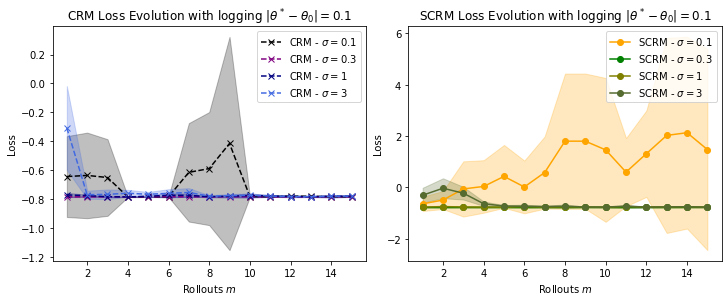

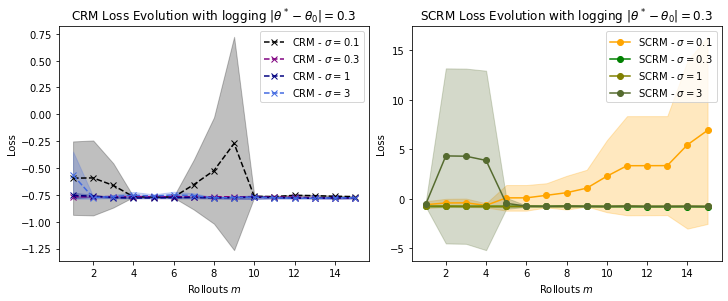

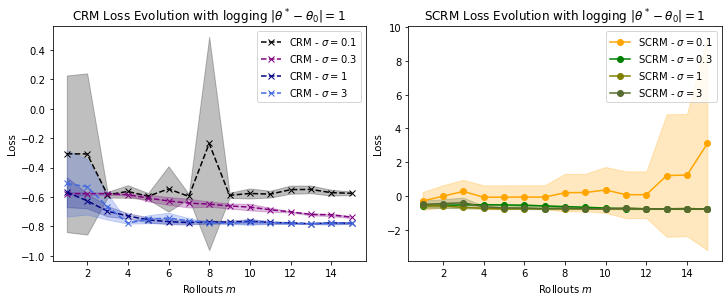

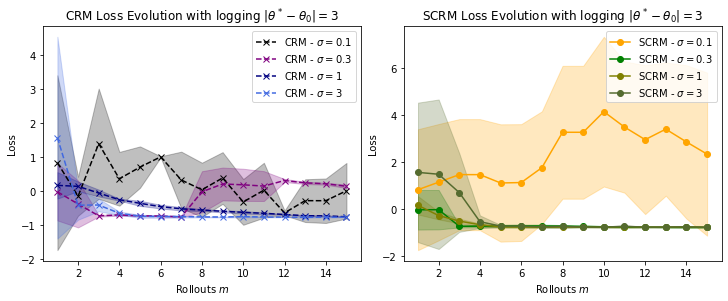

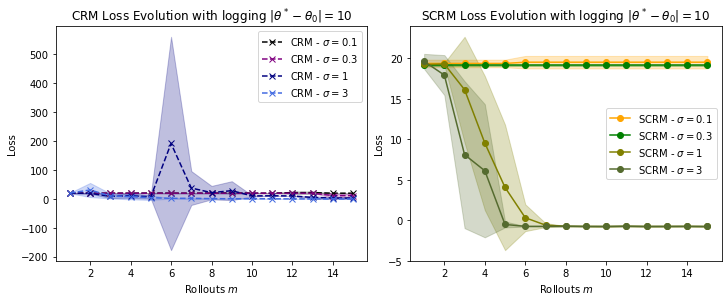

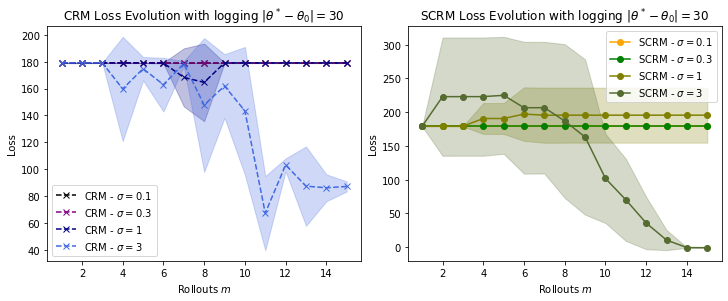

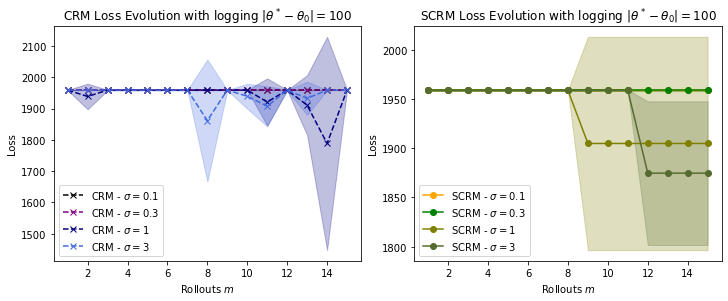

In [252]:
# deltas = [0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]

deltas = [0.1, 0.3, 1, 3, 10, 30, 100]

# deltas = [0.2, 0.5]
settings = {
    'M':15,
    'n_0':100
}

crm_perfs_by_delta = []
std_crm_perfs_by_delta = []
scrm_perfs_by_delta = []
std_scrm_perfs_by_delta = []

for delta in deltas:
    crm_perfs, crm_perfs_std, scrm_perfs, scrm_perfs_std = do_plot(delta, settings)
    crm_perfs_by_delta.append(crm_perfs)
    std_crm_perfs_by_delta.append(crm_perfs_std)
    scrm_perfs_by_delta.append(scrm_perfs)
    std_scrm_perfs_by_delta.append(scrm_perfs_std)

In [238]:
deltas

[0.1, 0.3, 1, 3, 10, 30, 100]

In [243]:
crm_perfs_by_delta

[[array([-0.64296004, -0.63486397, -0.6494168 , -0.78272431, -0.78229908,
         -0.78272791, -0.61364   , -0.58790216, -0.414316  , -0.78065167,
         -0.78190014, -0.77752976, -0.77894107, -0.78100773, -0.78221883]),
  array([-0.78269437, -0.78265911, -0.78248396, -0.78226502, -0.78236311,
         -0.78242474, -0.78248416, -0.78248966, -0.78250781, -0.78216465,
         -0.78243608, -0.78246034, -0.78302126, -0.78139138, -0.7818941 ]),
  array([-0.76968304, -0.77425593, -0.78200634, -0.78341547, -0.77867013,
         -0.77194632, -0.772369  , -0.78166906, -0.7783684 , -0.77408957,
         -0.77670186, -0.78058234, -0.7822589 , -0.7789968 , -0.77838592]),
  array([-0.3071353 , -0.76828984, -0.76546518, -0.75805735, -0.76514404,
         -0.75867562, -0.75282845, -0.77785022, -0.77451413, -0.77252084,
         -0.77714557, -0.78062136, -0.78199089, -0.7782651 , -0.77824039])],
 [array([-0.59477166, -0.59268698, -0.66255035, -0.76811719, -0.76961055,
         -0.77066008, -0.6546

In [47]:
np.concatenate(crm_perfs_by_delta).shape

(27, 10)

--------------------------------------------------------------------------------
CRM experiment, \mu_0=301, \sigma=0.1, seed 0
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
SCRM experiment, \mu_0=301, \sigma=0.1, seed 0
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
CRM experiment, \mu_0=301, \sigma=0.1, seed 1
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
SCRM experiment, \mu_0=301, \sigma=0.1, seed 1
Rollout 0
Rollout 1
Rollo

Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
CRM experiment, \mu_0=301, \sigma=3, seed 0
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
SCRM experiment, \mu_0=301, \sigma=3, seed 0
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------------------------------------------------------------------------
CRM experiment, \mu_0=301, \sigma=3, seed 1
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12
Rollout 13
Rollout 14
--------------

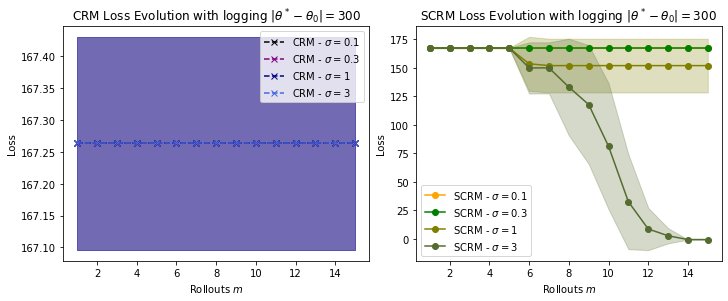

In [246]:
# crm_perfs_20, crm_perfs_std_20, scrm_perfs_20, scrm_perfs_std_20 = do_plot(20, settings)
crm_perfs_300, crm_perfs_std_300, scrm_perfs_300, scrm_perfs_std_300 = do_plot(300, settings)

In [49]:
last_losses_delta = [list_[-1] for list_ in crm_perfs_by_delta[0]]
last_losses_delta

[-0.7960394003730098, -0.9038471524669991, -0.434552505925528]

In [247]:
loss_s01, loss_s03, loss_s1, loss_s3 = [list_[-1] for list_ in crm_perfs_300]
minimal_loss = min([loss_s01, loss_s03, loss_s1, loss_s3])

crm_min_final_losses.append(minimal_loss)
crm_sigma_01_final_losses.append(loss_s01)
crm_sigma_03_final_losses.append(loss_s03)
crm_sigma_1_final_losses.append(loss_s1)
crm_sigma_3_final_losses.append(loss_s3)
#     crm_sigma_10_final_losses.append(loss_s10)

#SCRM
#     loss_s01, loss_s03, loss_s1, loss_s3, loss_s10 = [list_[-1] for list_ in scrm_perfs_by_delta[idx]]
loss_s01, loss_s03, loss_s1, loss_s3 = [list_[-1] for list_ in scrm_perfs_300]
minimal_loss = min([loss_s01, loss_s03, loss_s1, loss_s3])

scrm_min_final_losses.append(minimal_loss)
scrm_sigma_01_final_losses.append(loss_s01)
scrm_sigma_03_final_losses.append(loss_s03)
scrm_sigma_1_final_losses.append(loss_s1)
scrm_sigma_3_final_losses.append(loss_s3)

In [248]:
deltas = [0.1, 0.3, 1, 3, 10, 
          30, 100, 300]
# idx = deltas.index(20)
idx

6

In [211]:
# crm_min_final_losses.insert(deltas.index(20), min([list_[-1] for list_ in crm_perfs_20]))

In [219]:
crm_min_final_losses.insert(deltas.index(50), min([list_[-1] for list_ in crm_perfs_50]))

In [220]:
# scrm_min_final_losses.insert(deltas.index(20), min([list_[-1] for list_ in scrm_perfs_20]))
scrm_min_final_losses.insert(deltas.index(50), min([list_[-1] for list_ in scrm_perfs_50]))

In [244]:
crm_sigma_01_final_losses = []
crm_sigma_03_final_losses = []
crm_sigma_1_final_losses = []
crm_sigma_3_final_losses = []
# crm_sigma_10_final_losses = []
crm_min_final_losses = []

scrm_sigma_01_final_losses = []
scrm_sigma_03_final_losses = []
scrm_sigma_1_final_losses = []
scrm_sigma_3_final_losses = []
# scrm_sigma_10_final_losses = []
scrm_min_final_losses = []

deltas = [0.1, 0.3, 1, 3, 10, 30, 100]


for idx, delta in enumerate(deltas):
    
    # CRM
#     loss_s01, loss_s03, loss_s1, loss_s3, loss_s10 = [list_[-1] for list_ in crm_perfs_by_delta[idx]]
    loss_s01, loss_s03, loss_s1, loss_s3 = [list_[-1] for list_ in crm_perfs_by_delta[idx]]
    minimal_loss = min([loss_s01, loss_s03, loss_s1, loss_s3])
    
    crm_min_final_losses.append(minimal_loss)
    crm_sigma_01_final_losses.append(loss_s01)
    crm_sigma_03_final_losses.append(loss_s03)
    crm_sigma_1_final_losses.append(loss_s1)
    crm_sigma_3_final_losses.append(loss_s3)
#     crm_sigma_10_final_losses.append(loss_s10)
    
    #SCRM
#     loss_s01, loss_s03, loss_s1, loss_s3, loss_s10 = [list_[-1] for list_ in scrm_perfs_by_delta[idx]]
    loss_s01, loss_s03, loss_s1, loss_s3 = [list_[-1] for list_ in scrm_perfs_by_delta[idx]]
    minimal_loss = min([loss_s01, loss_s03, loss_s1, loss_s3])
    
    scrm_min_final_losses.append(minimal_loss)
    scrm_sigma_01_final_losses.append(loss_s01)
    scrm_sigma_03_final_losses.append(loss_s03)
    scrm_sigma_1_final_losses.append(loss_s1)
    scrm_sigma_3_final_losses.append(loss_s3)
#     scrm_sigma_10_final_losses.append(loss_s10)

In [130]:
sigma_01_final_losses, crm_sigma_01_final_losses

([-0.7960394003730098,
  -0.7581261856090473,
  -0.5544674216177888,
  -0.24970210498158818,
  -0.16617300302542645,
  -0.16617300302542645,
  -0.16617300302542645,
  -0.16617300302542645,
  -0.16617300302542645],
 [])

In [131]:
sigma_1_final_losses

[-0.9038471524669991,
 -0.9003137384002382,
 -0.8902516337608544,
 -0.8676695588968085,
 -0.2181406742124084,
 -0.16617300302542645,
 -0.16617300302542645,
 -0.16617300302542645,
 -0.16617300302542645]

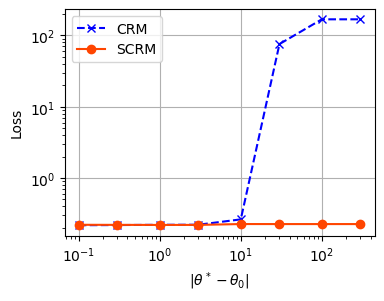

In [250]:
fig=plt.figure(figsize=(4,3), dpi= 100, facecolor='w', edgecolor='k')  # to have big plots
deltas = [0.1, 0.3, 1, 3, 10, 30, 100, 300]
plt.plot(deltas, np.array(crm_min_final_losses)+1, 'x--', color='blue', label='CRM')
# plt.fill_between(rollouts,
#                      crm_losses - crm_losses_std,
#                      crm_losses + crm_losses_std, alpha=.25, color=color_crm, )
plt.plot(deltas, np.array(scrm_min_final_losses)+1, 'o-', color='orangered', label='SCRM')
# plt.fill_between(rollouts,
#                      scrm_losses - scrm_losses_std,
#                      scrm_losses + scrm_losses_std, alpha=.25, color=color_scrm)
plt.xscale('log')
plt.yscale('log')
# plt.ylim(-1.2,5)
plt.ylabel('Loss')
plt.xlabel(r'$\vert\theta^* - \theta_0 \vert$')
plt.legend(loc='best')
plt.grid()

plt.savefig('distance_variance_compromise_.pdf', bbox_inches = "tight")

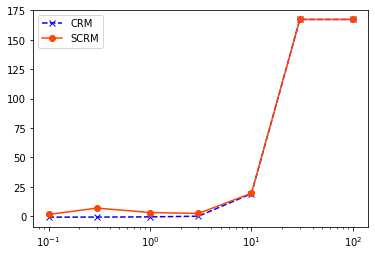

In [231]:
plt.plot(deltas, crm_sigma_01_final_losses, 'x--', color='blue', label='CRM')
# plt.fill_between(rollouts,
#                      crm_losses - crm_losses_std,
#                      crm_losses + crm_losses_std, alpha=.25, color=color_crm, )
plt.plot(deltas, scrm_sigma_01_final_losses, 'o-', color='orangered', label='SCRM')
# plt.fill_between(rollouts,
#                      scrm_losses - scrm_losses_std,
#                      scrm_losses + scrm_losses_std, alpha=.25, color=color_scrm)
plt.xscale('log')
plt.legend(loc='best')

In [99]:
crm_sigma_03_final_losses, crm_sigma_01_final_losses, scrm_sigma_03_final_losses

([-0.7303954558306722,
  -0.6199902078516804,
  -0.3294835113125127,
  1.5454831351752187,
  6.113182674744026,
  26.25124105658791,
  79.61971852865317,
  515.5446279646214,
  1959.1602010575248],
 [1.4717161894667081,
  3.0625014055308646,
  3.2931395872623193,
  6.362778839557658,
  8.38007357922537,
  26.986853608033293,
  78.8912133274442,
  498.5775269423619,
  1959.1602010575248],
 [25.10549273389133,
  16.81071533567439,
  18.05056631434225,
  29.918542412860955,
  26.58049597971982,
  39.28305840160447,
  102.55270319530061,
  500.1571857352337,
  1959.1602010575248])

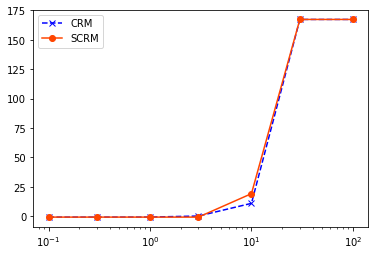

In [233]:
plt.plot(deltas, crm_sigma_03_final_losses, 'x--', color='blue', label='CRM')
# plt.fill_between(rollouts,
#                      crm_losses - crm_losses_std,
#                      crm_losses + crm_losses_std, alpha=.25, color=color_crm, )
plt.plot(deltas, scrm_sigma_03_final_losses, 'o-', color='orangered', label='SCRM')
# plt.fill_between(rollouts,
#                      scrm_losses - scrm_losses_std,
#                      scrm_losses + scrm_losses_std, alpha=.25, color=color_scrm)
plt.xscale('log')
# plt.ylim(-1,5)
# plt.yscale('log')
plt.legend(loc='best')

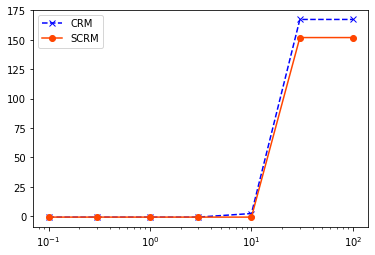

In [235]:
plt.plot(deltas, crm_sigma_1_final_losses, 'x--', color='blue', label='CRM')
# plt.fill_between(rollouts,
#                      crm_losses - crm_losses_std,
#                      crm_losses + crm_losses_std, alpha=.25, color=color_crm, )
plt.plot(deltas, scrm_sigma_1_final_losses, 'o-', color='orangered', label='SCRM')
# plt.fill_between(rollouts,
#                      scrm_losses - scrm_losses_std,
#                      scrm_losses + scrm_losses_std, alpha=.25, color=color_scrm)
plt.xscale('log')
# plt.ylim(-1,5)
plt.legend(loc='best')

In [62]:
scrm_sigma_1_final_losses

[-0.83102160140643,
 -0.8310906479113704,
 -0.8309544331275562,
 -0.8312666332098783,
 -0.8313633417932655,
 -0.831333367351651,
 -0.831333367351651,
 -0.831333367351651,
 -0.831333367351651]

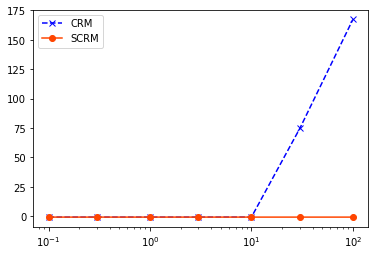

In [237]:
plt.plot(deltas, crm_sigma_3_final_losses, 'x--', color='blue', label='CRM')
# plt.fill_between(rollouts,
#                      crm_losses - crm_losses_std,
#                      crm_losses + crm_losses_std, alpha=.25, color=color_crm, )
plt.plot(deltas, scrm_sigma_3_final_losses, 'o-', color='orangered', label='SCRM')
# plt.fill_between(rollouts,
#                      scrm_losses - scrm_losses_std,
#                      scrm_losses + scrm_losses_std, alpha=.25, color=color_scrm)
plt.xscale('log')
# plt.ylim(-1,5)
plt.legend(loc='best')

In [75]:
test

NameError: name 'test' is not defined

In [168]:
crm_array = np.vstack([np.array(crm_sigma_01_final_losses), np.array(crm_sigma_03_final_losses), np.array(crm_sigma_1_final_losses) , np.array(crm_sigma_3_final_losses)])

In [163]:
np.array(crm_sigma_1_final_losses)

array([-0.77408957, -0.77205272, -0.76673407, -0.63494721,  9.72496249,
       15.3684864 ])

In [169]:
crm_array 

array([[-0.78065167, -0.76414843, -0.57643406, -0.32862842, 15.3684864 ,
        15.3684864 ],
       [-0.78216465, -0.76894752, -0.66928667,  0.17594867, 15.3684864 ,
        15.3684864 ],
       [-0.77408957, -0.77205272, -0.76673407, -0.63494721,  9.72496249,
        15.3684864 ],
       [-0.77252084, -0.77153448, -0.77137909, -0.762614  , -0.18904509,
        15.3684864 ]])

In [170]:
crm_array_1 = np.minimum(np.array(crm_sigma_01_final_losses), np.array(crm_sigma_03_final_losses))
, np.array(crm_sigma_1_final_losses) , np.array(crm_sigma_3_final_losses))

ValueError: invalid number of arguments